In [24]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report
from xgboost import XGBClassifier
from scipy import stats


import warnings 
warnings.filterwarnings("ignore")

In [25]:
dataframe = pd.read_csv('train.csv')
dataframe.columns = ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']
dataframe['Location'] = dataframe['Location'].astype('object')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17109 entries, 0 to 17108
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          17109 non-null  object 
 1   Location      17109 non-null  object 
 2   MinTemp       17037 non-null  float64
 3   MaxTemp       17067 non-null  float64
 4   Rainfall      16944 non-null  float64
 5   Evaporation   9871 non-null   float64
 6   Sunshine      9051 non-null   float64
 7   WindDir9am    15926 non-null  object 
 8   WindDir3pm    16702 non-null  object 
 9   WindSpeed9am  16962 non-null  float64
 10  WindSpeed3pm  16815 non-null  float64
 11  Humidity9am   16923 non-null  float64
 12  Humidity3pm   16710 non-null  float64
 13  Pressure9am   15448 non-null  float64
 14  Pressure3pm   15453 non-null  float64
 15  Cloud9am      10681 non-null  float64
 16  Cloud3pm      10238 non-null  float64
 17  Temp9am       17015 non-null  float64
 18  Temp3pm       16803 non-nu

In [26]:
# 若我是使用 決策樹 或 隨機森林，我會先將日期刪除，因為日期不會影響到結果
dataframe.drop("Date", axis=1, inplace=True)

In [27]:
dataframe.drop(['Temp9am', 'Temp3pm'], axis=1, inplace=True)

In [28]:
# 取得 類別型 以及 數值型 的欄位
def get_num_cat_col(df):
    cat_cols = dataframe.select_dtypes(include=['object']).columns
    num_cols = dataframe.select_dtypes(exclude=['object']).columns
    return cat_cols, num_cols

In [29]:
categorical_cols, numerical_cols = get_num_cat_col(dataframe)

In [30]:
# num -> median , cat -> most_frequent
for col in numerical_cols:
    dataframe[col]= dataframe[col].fillna(dataframe[col].median())

In [31]:
for col in categorical_cols:
    dataframe[col] = dataframe[col].fillna(dataframe[col].mode()[0])

In [32]:
print(dataframe.isnull().sum())

Location        0
MinTemp         0
MaxTemp         0
Rainfall        0
Evaporation     0
Sunshine        0
WindDir9am      0
WindDir3pm      0
WindSpeed9am    0
WindSpeed3pm    0
Humidity9am     0
Humidity3pm     0
Pressure9am     0
Pressure3pm     0
Cloud9am        0
Cloud3pm        0
RainToday       0
RainTomorrow    0
dtype: int64


In [33]:
dataframe['high_sun'] = np.where(dataframe['Sunshine'] > 9, 1, 0)
dataframe['Humidity3pm_60'] = np.where(dataframe['Humidity3pm'] >= 70, 1, 0)
dataframe['Cloud3pm_6'] = np.where(dataframe['Cloud3pm'] > 6, 1, 0)
dataframe['Location'] = dataframe['Location'].astype('object')

In [34]:
# 去除 3 個標準差的 離群值
for col in numerical_cols:
    dataframe = dataframe[np.abs(stats.zscore(dataframe[col])) < 3]

In [35]:
no_yes_col = ['RainToday', 'RainTomorrow']
for col in no_yes_col:
    dataframe[col] = dataframe[col].map({'No': 0, 'Yes': 1})

In [36]:
cat_col = ['Location', 'WindDir9am', 'WindDir3pm']
# one-hot encoding
dataframe= pd.get_dummies(dataframe, columns=cat_col)
print(dataframe.shape)

(15911, 99)


In [37]:
# split data into train and test sets
X = dataframe.drop(['RainTomorrow'], axis=1)
y = dataframe['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# oversampling
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

Accuracy:[0.8645931511153]
ROC AUC:[0.7643996806348772]
Recall:[0.6321243523316062]
Precision:[0.45778611632270166]
F1-Score:[0.5310119695321001]
Classifiaction Reoprt
---------------------
              precision    recall  f1-score   support

           0      0.897     0.946     0.921      2650
           1      0.632     0.458     0.531       533

    accuracy                          0.865      3183
   macro avg      0.764     0.702     0.726      3183
weighted avg      0.852     0.865     0.856      3183

Confusion_Matrix
---------------------


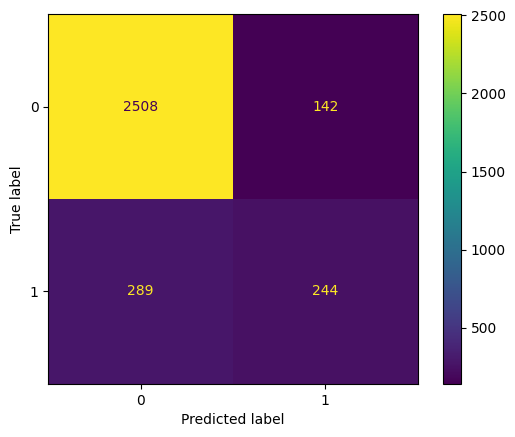

In [39]:
accuracy_result = []
recall_scores = []
precision_scores = []
roc_auc_scores = []
f1_scores = []

# Create the Model
clf_rf= RandomForestClassifier(max_features=20,min_samples_leaf=10,min_samples_split=2,n_estimators=400,random_state=42)
clf_lr= LogisticRegression(penalty='l1' , solver='liblinear')
clf_svm=SVC(kernel='linear', gamma='scale')
clf_gbc=GradientBoostingClassifier(min_samples_split=6, min_samples_leaf=10)
params_xgb = {
            'max_depth': 36,
            'device': 'cuda',
            'tree_method': 'hist',
            'objective': 'binary:logistic',
            'n_estimators': 400,
            'random_state': 42,
            }
clf_xgb = XGBClassifier(n_estimators=500,
                        max_depth=25,
                        learning_rate=0.1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        missing=-999,
                        verbose=2,
                        random_state=42)
# Create Votingclassifier Model
voting_clf= VotingClassifier(estimators=[('rf', clf_rf), ('lr', clf_lr), ('svm', clf_svm), ('gbc', clf_gbc), ('xgb', clf_xgb)], voting='hard', n_jobs=-1)
voting_clf.fit(X_train,y_train)
y_pred=voting_clf.predict(X_test)


# Save the result into List
accuracy_result.append(accuracy_score(y_pred,y_test))
recall_scores.append(recall_score(y_pred, y_test))
precision_scores.append(precision_score(y_pred, y_test))
f1_scores.append(f1_score(y_pred, y_test))
roc_auc_scores.append(roc_auc_score(y_pred, y_test))

# Print the Results
print(f"Accuracy:{accuracy_result}")
print(f"ROC AUC:{roc_auc_scores}")
print(f"Recall:{recall_scores}")
print(f"Precision:{precision_scores}")
print(f"F1-Score:{f1_scores}")
print("Classifiaction Reoprt")
print("---------------------")
print(classification_report(y_test,y_pred,digits=3))
print("Confusion_Matrix")
print("---------------------")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [40]:
model_names = ['VotingClassifier']
result_df = pd.DataFrame({'Recall':recall_scores, 'Precision':precision_scores, 'F1_Score':f1_scores, 'Accuracy': accuracy_result, 'ROC_AUC_Score':roc_auc_scores},index=model_names)

In [41]:
result_df.T.sort_values(by="VotingClassifier", ascending=False)

,VotingClassifier
Accuracy,0.864593
ROC_AUC_Score,0.764400
Recall,0.632124
F1_Score,0.531012
Precision,0.457786


In [42]:
test_df = pd.read_csv('test.csv')
test_df.columns = ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
test_df['Location'] = test_df['Location'].astype('object')
test_df.drop("Date", axis=1, inplace=True)
test_df.drop(['Temp9am', 'Temp3pm'], axis=1, inplace=True)

In [43]:
test_df['RainToday'] = dataframe['RainToday'].map({'No': 0, 'Yes': 1})
cat_col = ['Location', 'WindDir9am', 'WindDir3pm']
test_df = pd.get_dummies(test_df, columns=cat_col)
# 新增的欄位，若在 test_df 中沒有，則新增一個全為 0 的欄位
for col in dataframe.columns:
    if col not in test_df.columns:
        if col != 'RainTomorrow':
            test_df[col] = 0

# place the columns in the same order, exclude RainTomorrow
cols = dataframe.columns.tolist()
cols.remove('RainTomorrow')
test_df = test_df[cols]

In [44]:
test_df.fillna(0, inplace=True)

In [45]:
# predict
y_pred = voting_clf.predict(test_df)
print(y_pred.tolist().count(1))
print(y_pred.tolist().count(0))
count = y_pred.tolist().count(1)

328
495


In [46]:
df_submit = pd.DataFrame(columns=['id', 'ans'])
# col 為 id 跟 ans
for i in range(len(y_pred)):
    df_submit.loc[i] = [i, y_pred[i]]

# 把 id 轉成 string
df_submit['id'] = df_submit['id'].astype('float64')
df_submit['ans'] = df_submit['ans'].astype('int32')
# 寫入 2023-11-07-submit.csv
df_submit.to_csv('2023-11-30-submit-votingCLF-'+ str(count) +'.csv', index=False)
# 計算 df_submit
df_submit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 823 entries, 0 to 822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      823 non-null    float64
 1   ans     823 non-null    int32  
dtypes: float64(1), int32(1)
memory usage: 16.1 KB
